# Yakuy Code : Shopee Week 6 ~ Sentiment Analisis
Special thanks to Tony Ng for providing addictional dataset <a href="https://www.kaggle.com/shymammoth/shopee-reviews">disini</a>.
### Kelebihan :
1. Cukup mudah karena tidak melakukan preprocess data.
2. Hasil yang diberikan cukup besar mengingat kode yang digunakan tidak terlalu ribet.
### Kekurangan : 
1. Model yang dihasilkan tidak dapat membedakan kelas 5 dan 4.
2. Hasil prediksi terlalu banyak pada kelas 5.
3. Mungkin hasil yang diberikan bisa lebih besar jika dilakukan preprocess data
### Main Idea :
1. Concatting data train lama dengan data baru dengan proporsi tertentu<br>
2. Menentukan Pretrained model yang akan digunakan.<br>
Disini akan digunakan XLM-Roberta karena pretrained model ini dapat menghandle banyak bahasa dan sifat dari tokenizenya cukup soft.<br>
Pretrained model lain yang disarankan : Bert Multilangual Cased.
3. Menentukan besar sequence terpanjang yang akan di olah dari distribusi tokennya.<br>
4. Membuat model XLMRoberta pada bagian inputnya dan kustomisasi untuk bagian outputnya agar model sesuai dengan yang diharapkan<br>
5. Encoding data test terlebih dahulu<br>
6. Melakukan Stratified Kfold untuk Cross Validitation sebanyak 3 split.<br>
7. Melakukan fitting model pada ketiga data train pada foldnya lalu membuat prediksi pada data test dari ketiga model tersebut<br>
8. Melakukan pooling dari hasil prediksi dengan `numpy argmax`<br>
9. Membuat data Submission
### Note :
1. Masih menjadi pertanyaan kenapa pas dilakukan preprocess data pada model bert akurasinya malah turun bukannya naik, walaupun gw belum nyoba untuk model yang `XLMRoberta` ini.

## 1. Import Libraries
Import dulu gan ~

In [1]:
# Basic
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Tensorflow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

# Huggingface
import transformers
from transformers import *

# Scikit Learn 
from sklearn.model_selection import StratifiedKFold

warnings.simplefilter("ignore")
plt.style.use('ggplot')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
print('Tensorflow version  ', tf.__version__)
print('Transformer version ', transformers.__version__)

Tensorflow version   2.2.0
Transformer version  2.11.0


Config untuk konfigurasi pada model nantinya.<br>
Model yang akan digunakan adalah `jplu/tf-xlm-roberta-base` dari librari Transformers (Huggingface)<br>
Model yang ada pada library Huggingface ada <a href="https://huggingface.co/transformers/pretrained_models.html">disini</a>

In [3]:
# Configuration
EPOCHS = 10
MODEL = 'jplu/tf-xlm-roberta-base'

## 2. Load dataset

In [4]:
# Load main dataset
train = pd.read_csv('../input/student-shopee-code-league-sentiment-analysis/train.csv')
test = pd.read_csv('../input/student-shopee-code-league-sentiment-analysis/test.csv')
train.head()

,review_id,review,rating
0,0,Ga disappointed neat products .. Meletot Hilsn...,1
1,1,"Rdtanya replace broken glass, broken chargernya",1
2,2,Nyesel bngt dsni shopping antecedent photo mes...,1
3,3,Sent a light blue suit goods ga want a refund,1
4,4,Pendants came with dents and scratches on its ...,1


In [5]:
# Dropping duplicate value karena akan sangat berpengaruh pada nilai Cross Validation nantinya
train['review'] = train.review.apply(lambda x : x.lower())
train = shuffle(train.drop_duplicates('review'), random_state = 42).reset_index(drop=True)
train.head()

,review_id,review,rating
0,75950,mantullllll. i like you like she likes. all lo...,4
1,116802,"ky package, fast delivery. sua genuine, date: ...",5
2,71108,sp vs buy cheap. ok. y shape 👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌👌...,4
3,83408,product quality is very good very good value ...,4
4,139373,"kind received great! no flaws, but also a very...",5


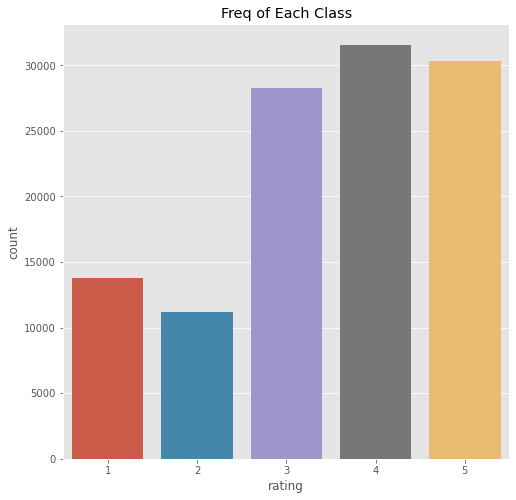

In [6]:
plt.figure(figsize=(8,8))
sns.countplot(train['rating'])
plt.title('Freq of Each Class')
plt.show()

In [7]:
# Load Additional Dataset
new = pd.read_csv('../input/shopee-reviews/shopee_reviews.csv')
new = new[new['label'] != 'label'].reset_index(drop=True)
new['label'] = new['label'].astype(int)
new['text'] = new.text.apply(lambda x : x.lower())
new = shuffle(new.drop_duplicates('text'), random_state = 42).reset_index(drop=True)
new = new.rename(columns={'label': 'rating', 'text' : 'review'})
new

,rating,review
0,5,well received. fast delivery. considering get...
1,5,received in good condition. working well.
2,5,received item in good condition. fast delivery...
3,4,good value 1 for 1 so bought 4 boxes but total...
4,5,the toys are wrapped up in bubble bag and deli...
...,...,...
1494507,5,"came nicely packed, delivery time was okay. wa..."
1494508,5,item as per described. good quality and fast d...
1494509,5,good delivery service. the items look good. ye...
1494510,5,comfy. not the hot material. just like normal ...


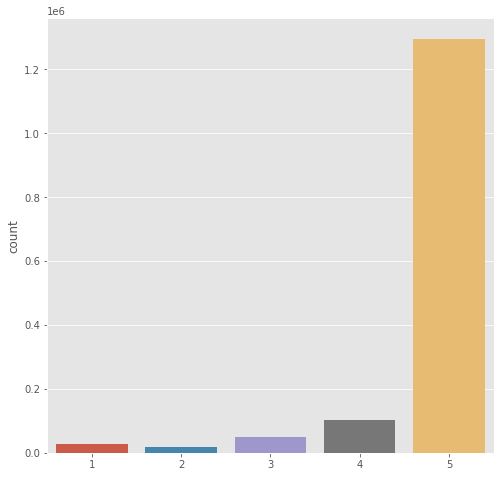

In [8]:
plt.figure(figsize = (8,8))
sns.countplot(new.rating.values)
plt.show()

In [9]:
def concat(a, b, target, num):
    """
    Fungsi untuk menggabungkan 2 Dataframe dengan proporsi tertentu.
    """
    for i in a[target].value_counts().keys():
        temp = num - sum(a[target] == i)
        if temp > 0:
            if sum(a[target] == i) + sum(b[target] == i) >= num:
                a = pd.concat([a, b[b[target] == i].sample(n=temp, random_state=42)])
            else:
                a = pd.concat([a, b[b[target] == i]])
    return a.reset_index(drop=True)

Karena data tambahan memiliki ketidakseimbangan kelas yang parah jadi kita hanya akan mengambil data secukupnya dari data tersebut.<br>
Disini kita hanya ingin mengambil beberapa data agar masing masing kelas pada data utama menjadi sebanyak 40k data.

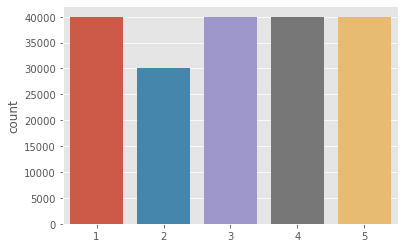

In [10]:
fixed = concat(train, new, 'rating', 40000)
sns.countplot(fixed.rating.values)

## 3. Tokenizer
Tokenizer adalah fungsi yang bertugas mengubah data kata" menjadi angka". Tokennizer yang akan digunakan disini adalah tokenizer khusus yang diperlukan dari pretrained model kita yaitu `XLMRobertaTokenizer`.

In [11]:
# First load the real tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL, add_prefix_space=True, lowercase = True, add_special_tokens=True)

Checking distribusi dari banyaknya kata perkalimat yang aka kita olah untuk menentukan panjang kata terbanyak yang akan diproses perkalimatnya.

In [12]:
fixed.review.apply(lambda x : len(tokenizer.encode(x))).describe()

count    190178.000000
mean         27.342626
std          19.178036
min           2.000000
25%          14.000000
50%          22.000000
75%          35.000000
max         579.000000
Name: review, dtype: float64

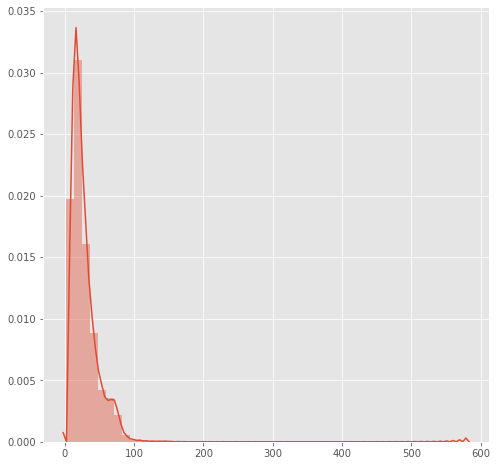

In [13]:
plt.figure(figsize=(8,8))
sns.distplot(fixed.review.apply(lambda x : len(tokenizer.encode(x))).values)
plt.show()

Dilihat dari grafiknya dapat disimpulkan bahwa kira kira 100 kata perkalimatnya sudah cukup untuk model kita teliti

In [14]:
MAX_LEN = 100

In [15]:
# Cek Kerja Tokenizer
print(' Actual '.center(14, '#'))
print(test.review.values[4])
print(' Tokenized '.center(14, '#'))
print(tokenizer.tokenize(test.review.values[4]))
print(' Ids '.center(14, '#'))
print(tokenizer.encode(test.review.values[4]))

### Actual ###
it's sooooo cute! i like playing with the glitters better than browsing on my phone now. item was also deliered earlier than i expected. thank you seller! may you have more buyers to come. 😊😊😊
# Tokenized ##
['▁it', "'", 's', '▁so', 'oooo', '▁cute', '!', '▁i', '▁like', '▁playing', '▁with', '▁the', '▁glitter', 's', '▁better', '▁than', '▁browsing', '▁on', '▁my', '▁phone', '▁now', '.', '▁item', '▁was', '▁also', '▁de', 'lier', 'ed', '▁earlier', '▁than', '▁i', '▁expected', '.', '▁thank', '▁you', '▁selle', 'r', '!', '▁may', '▁you', '▁have', '▁more', '▁buy', 'ers', '▁to', '▁come', '.', '▁', '😊', '😊', '😊']
#### Ids #####
[0, 442, 25, 7, 221, 61957, 99942, 38, 17, 1884, 75169, 678, 70, 186116, 7, 11522, 3501, 231602, 98, 759, 24089, 5036, 5, 35735, 509, 2843, 8, 56786, 297, 110680, 3501, 17, 84751, 5, 51544, 398, 7666, 42, 38, 1543, 398, 765, 1286, 22113, 1314, 47, 1380, 5, 6, 82803, 82803, 82803, 2]


In [16]:
# Konfigurasi Untuk TPU
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [17]:
# Batch Tokenizer
def tokenize(sentences, tokenizer, maxlen = 512):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, pad_to_max_length=True, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return [np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')]

In [18]:
# Encoding data test terlebih dahulu
x_test = tokenize(test.review.values, tokenizer, maxlen = MAX_LEN)

## 4. Fungsi untuk Membuat Model
Membuat fungsi untuk membuat model agar dapat dipanggi sewaktu waktu pada proses cross validitation.<br>
Model terinspirasi dari <a href="https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705">sini</a>

In [19]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32, name='input_ids')
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32, name='attention_mask')
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32, name='token_type_ids')

    config = XLMRobertaConfig.from_pretrained(MODEL)
    bert_model = TFXLMRobertaModel.from_pretrained(MODEL, config=config)
    pooled_output, sequence_output = bert_model(ids,
                   attention_mask=att,
                   token_type_ids=tok)
    X = Flatten()(pooled_output)
    X = tf.keras.layers.Dense(256, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.35)(X)
    X = tf.keras.layers.Dense(5, activation='softmax')(X)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs = X)
    
    for layer in model.layers[:3]:
        layer.trainable = False
        
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

    return model

## 5. Statified Kfold
Proses ini adalah proses utamanya. Pada tahap ini kita membagi data train menjadi 3 Fold karena Session TPU pada kaggle itu cuman bisa 3 jam jadi biar cukup waktunya jadi 3 Fold aja wkwk (kalo bisasih lebih baik 5 Fold). Kenapa Stratfied Kfold? Karena data yang kita punya itu kelasnya sangat imbalance jadi Stratfied Kfold punya kelebihan dari Kfold yang biasa

In [20]:
# X dan y Train
X = fixed.review.values
y = fixed.rating.values

# Strarified Kfold
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state = 42)
# Array kosong yang akan diisi nantinya dari setiap model per Foldnya
pred = np.zeros(shape = (len(test.review.values), 5))
# Menyimpan Validation Accuracy dari setiap model per Foldnya
scores = []

for fold, (train_ind, test_ind) in enumerate(kfold.split(X, y)):
    # Cleaning everything
    K.clear_session()
    tf.tpu.experimental.initialize_tpu_system(tpu)

    # Mengambil data perFoldnya
    print('[INFO] Working on Batch :', fold + 1)
    x_train, y_train = X[train_ind], to_categorical(y[train_ind] - 1)
    x_val, y_val = X[test_ind], to_categorical(y[test_ind] - 1)

    # Encoding train dataset perFoldnya
    print('[INFO] Encoding text')
    x_train = tokenize(x_train, tokenizer, maxlen=MAX_LEN)
    x_valid = tokenize(x_val, tokenizer, maxlen=MAX_LEN)
    
    # Fitting model perFoldnya
    print('[INFO] Fitting Model')
    with strategy.scope():
        model = build_model()

    # Callbacks    
    sv = ModelCheckpoint(
        f'Model XLMRoberta.h5', monitor='val_accuracy', save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch'
    )
    callbacks = [sv, ReduceLROnPlateau(monitor='val_loss', patience=1, cooldown=0),
                EarlyStopping(monitor='val_loss', min_delta=1e-5, patience = 2)]

    # Fitting Model    
    train_history = model.fit(
        {'input_ids': x_train[0], 'attention_mask': x_train[1], 'token_type_ids': x_train[2]}, y_train,
        steps_per_epoch = len(train_ind)//32,
        validation_data = ({'input_ids': x_valid[0], 'attention_mask': x_valid[1], 'token_type_ids': x_valid[2]}, 
                           y_val),
        callbacks = callbacks,
        batch_size = 32,
        epochs = 10
        )
    
    # Meload model terbaik dari epochnya 
    print('[INFO] Loading Model')
    model.load_weights('Model XLMRoberta.h5')
    
    # Melihat Score dari Val_Accuracy 
    print('[INFO] Evaluating Model')
    score = model.evaluate({'input_ids': x_valid[0], 'attention_mask': x_valid[1], 'token_type_ids': x_valid[2]}, 
                           y_val, verbose = 1)[1]
    scores.append(score)
    
    # Membuat prediksi untuk test data lalu dijumlahkan pada array awal
    print('[INFO] Making Prediction')
    prediction = model.predict({'input_ids': x_test[0], 'attention_mask': x_test[1], 'token_type_ids': x_test[2]}, verbose = 1)
    pred += prediction
    
    # Menghapus model yang disimpan perFoldnya untuk efesiensi memori session kaggle
    print('[INFO] Removing Model')
    !rm 'Model XLMRoberta.h5'
    print()

[INFO] Working on Batch : 1
[INFO] Encoding text
[INFO] Fitting Model



Epoch 1/10
3962/3962 [==============================] - 454s 115ms/step - accuracy: 0.4591 - loss: 1.1794 - val_accuracy: 0.4922 - val_loss: 1.0908 - lr: 3.0000e-05
Epoch 2/10
3962/3962 [==============================] - 450s 113ms/step - accuracy: 0.4934 - loss: 1.0984 - val_accuracy: 0.5037 - val_loss: 1.0773 - lr: 3.0000e-05
Epoch 3/10
3962/3962 [==============================] - 438s 111ms/step - accuracy: 0.3055 - loss: 1.4371 - val_accuracy: 0.2103 - val_loss: 1.6064 - lr: 3.0000e-05
Epoch 4/10
3962/3962 [==============================] - 432s 109ms/step - accuracy: 0.5538 - loss: 0.9484 - val_accuracy: 0.5077 - val_loss: 1.0764 - lr: 3.0000e-06
[INFO] Loading Model
[INFO] Evaluating Model
 100/1981 [>.............................] - ETA: 35s - accuracy: 0.4787 - loss: 1.0978

## 6. Memproses hasil prediksi

In [21]:
# Rata-rata Val_Accuracy dari setiap foldnya
print('[INFO] Mean CV Accuracy', sum(scores)/3)
# Memilih kelas dengan prediksi peluang terbesar 
predict = [np.argmax(x) + 1 for x in pred]

[INFO] Mean CV Accuracy 0.5080503622690836


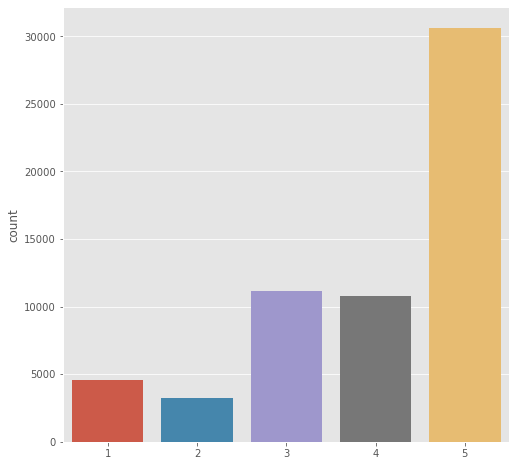

In [22]:
# Check banyak prediksi prekelasinya
plt.figure(figsize = (8, 8))
sns.countplot(predict)
plt.show()

##  7. Membuat Submission

In [23]:
test['rating'] = predict
sub = test[['review_id', 'rating']]
sub

,review_id,rating
0,1,3
1,2,2
2,3,5
3,4,5
4,5,5
...,...,...
60422,60423,4
60423,60424,3
60424,60425,4
60425,60426,5


In [24]:
sub.to_csv('Submission.csv', index = False)

## Renference
1. TensorFlow roBERTa - 0.705 <a href="https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705">link</a>
2. XLM-RoBERTa <a href="https://huggingface.co/transformers/model_doc/xlmroberta.html">link</a>